In [2]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [3]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
! nvidia-smi

Mon May  9 12:40:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 35%   44C    P8    39W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [5]:
from pymongo import MongoClient
import pymongo

In [6]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    db_de = db.patent_de
    db_us = db.patent_us
    db_cn = db.patent_cn
    db_rm_cn_5 = db.rm_patent_cn_5
    db_rm_cn_10 = db.rm_patent_cn_10
    db_rm_us_5 = db.rm_patent_us_5
    db_rm_us_10 = db.rm_patent_us_10
    db_rm_de_5 = db.rm_patent_de_5
    db_rm_de_10 = db.rm_patent_de_10
    
except errors.ConnectionFailure as err:
    print(err)

# 前五年

## Company數量

In [7]:
data_assignee = db_rm_de_5.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [8]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
# data_assignee = db_rm_cn_5.aggregate([
#     {"$unwind" : "$current_assignee"},
#     {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
#     {"$sort": {"count":-1}},
#     {"$limit":30}
# ])

# ls_company = []
# ls_count = []
# for data in data_assignee:
#     # print(data["_id"],data["count"])
#     ls_company.append(data["_id"])
#     ls_count.append(data["count"])
    
# df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
data_assignee = db_rm_us_5.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [11]:
final_df = pd.concat([df_family_de,df_family_us],axis=0)

In [12]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
45,Samsung Electronics Co Ltd,376
23,Intel Corp,349
8,Cisco Technology Inc,224
40,Qualcomm Inc,179
48,Telefonaktiebolaget LM Ericsson AB,146
30,LG Electronics Inc,71
26,International Business Machines Corp,60
33,Microsoft Technology Licensing LLC,57
9,Convida Wireless LLC,55
2,Afero Inc,52


In [13]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

In [14]:
com_df.reset_index(drop=True, inplace=True)

In [15]:
# com_ls = list(final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)["company"])
# com_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Huawei Technologies Co Ltd',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Apple Inc',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Micron Technology Inc',
 'Sony Corp',
 'Nokia Technologies Oy',
 'Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'NTT Docomo Inc']

In [16]:
# com_ls=['Qualcomm Inc', 'Samsung Electronics Co Ltd', 'Intel Corp', 'Telefonaktiebolaget LM Ericsson AB', 'Huawei Technologies Co Ltd', 'LG Electronics Inc', 'International Business Machines Corp', 'Apple Inc', 'Cisco Technology Inc', 'Microsoft Technology Licensing LLC', 'Micron Technology Inc', 'Sony Corp', 'Nokia Technologies Oy', 'Shenzhen Shenglu IoT Communication Technology Co Ltd', 'NTT Docomo Inc']

In [17]:
# com_count = [8491,6337,3236,2488,2461,1931,1591,1104,1092,963,731,711,668,656,612]

In [18]:
# com_df = pd.DataFrame((zip(com_ls, com_count)), columns = ['company', 'count'])

In [19]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))

In [20]:
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,376,5.929589
1,Intel Corp,349,5.855072
2,Cisco Technology Inc,224,5.411646
3,Qualcomm Inc,179,5.187386
4,Telefonaktiebolaget LM Ericsson AB,146,4.983607
5,LG Electronics Inc,71,4.262680
6,International Business Machines Corp,60,4.094345
7,Microsoft Technology Licensing LLC,57,4.043051
8,Convida Wireless LLC,55,4.007333
9,Afero Inc,52,3.951244


In [21]:
com_ls = list(com_df.company)

## Data

In [22]:
ccontry = pd.read_csv("./final_data/rm_company_country_de_us_5.csv")

In [23]:
ccpc = pd.read_csv("./final_data/rm_company_cpc_de_us_5.csv")

In [24]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AR,AT,AU,BR,CA,CH,CN,DE,DK,...,RS,RU,SA,SE,SG,TW,UA,US,WO,ZA
27,Afero Inc,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,10.0,0.0
47,Apple Inc,0.0,0.0,2.0,12.0,2.0,0.0,54.0,10.0,0.0,...,0.0,3.0,0.0,1.0,0.0,18.0,0.0,70.0,58.0,0.0
124,Cisco Technology Inc,0.0,0.0,1.0,0.0,13.0,0.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.0,84.0,0.0
135,Convida Wireless LLC,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,55.0,0.0
184,Electronics and Telecommunications Research In...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0


## Similarity計算

### Country

- 換成機率  

In [25]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [26]:
P = ccontry2[ccontry2.index==com_ls[0]].values.tolist()[0][1:]
Q = ccontry2[ccontry2.index==com_ls[1]].values.tolist()[0][1:]

In [27]:
# print(P)
# print(Q)

### PBC
- 和Samsung Electronics Co Ltd比較

In [28]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc

,AR,AT,AU,BR,CA,CH,CN,DE,DK,EA,...,RS,RU,SA,SE,SG,TW,UA,US,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.0,0.007359,0.000000,0.002453,0.0,0.120196,0.013083,0.000000,0.0,...,0.000000,0.000818,0.000000,0.000000,0.000000,0.013900,0.0,0.315617,0.127555,0.000000
Intel Corp,0.000000,0.0,0.000000,0.016047,0.000000,0.0,0.135980,0.021959,0.000000,0.0,...,0.000000,0.002534,0.000000,0.000000,0.004223,0.054054,0.0,0.320946,0.216216,0.000000
Cisco Technology Inc,0.000000,0.0,0.002299,0.000000,0.029885,0.0,0.045977,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.519540,0.193103,0.000000
Qualcomm Inc,0.000000,0.0,0.003341,0.022272,0.005568,0.0,0.142539,0.000000,0.000000,0.0,...,0.001114,0.000000,0.001114,0.000000,0.001114,0.037862,0.0,0.199332,0.184855,0.000000
Telefonaktiebolaget LM Ericsson AB,0.008977,0.0,0.003591,0.016158,0.007181,0.0,0.100539,0.000000,0.007181,0.0,...,0.000000,0.008977,0.000000,0.000000,0.001795,0.008977,0.0,0.265709,0.251346,0.008977
LG Electronics Inc,0.000000,0.0,0.008000,0.000000,0.008000,0.0,0.096000,0.000000,0.000000,0.0,...,0.000000,0.008000,0.000000,0.000000,0.000000,0.004000,0.0,0.288000,0.272000,0.000000
International Business Machines Corp,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.137255,0.068627,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.588235,0.039216,0.000000
Microsoft Technology Licensing LLC,0.000000,0.0,0.010417,0.010417,0.010417,0.0,0.166667,0.000000,0.000000,0.0,...,0.000000,0.010417,0.000000,0.000000,0.000000,0.010417,0.0,0.302083,0.250000,0.000000
Convida Wireless LLC,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.148789,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.190311,0.190311,0.000000


In [29]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [30]:
pbc_ls=[]
n=0.05

for i in ccontry_pbc.index:
    pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccontry_pbc["pbc"]=pbc_ls

In [31]:
# ccontry_pbc.sort_values(["pbc"],ascending=True)

### CPC

In [32]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [33]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [34]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [35]:
pbc_ls=[]
n=0.06

for i in ccpc_pbc.index:
    pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccpc_pbc["pbc"]=pbc_ls

In [36]:
ccpc_pbc.sort_values(["pbc"],ascending=True)

,A01,A23,A41,A42,A44,A46,A47,A61,A62,A63,...,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum,pbc
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.019023,0.00000,0.003975,...,0.075241,0.008234,0.005395,0.524418,0.017036,0.019875,0.000568,0.001704,0.326636,0.326636
Intel Corp,0.001823,0.0,0.000608,0.0,0.0,0.000608,0.001519,0.017315,0.00000,0.023390,...,0.109356,0.013062,0.007594,0.547084,0.003038,0.023998,0.000911,0.000608,0.330632,0.330965
Cisco Technology Inc,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000734,0.000000,0.00000,0.000000,...,0.001467,0.010271,0.000734,0.815847,0.000734,0.028613,0.019076,0.000000,0.450394,0.466489
Microsoft Technology Licensing LLC,0.000000,0.0,0.004338,0.0,0.0,0.000000,0.000000,0.004338,0.00000,0.000000,...,0.045553,0.030369,0.000000,0.318872,0.008677,0.019523,0.006508,0.000000,0.255275,0.468816
International Business Machines Corp,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.007317,0.021951,0.00000,0.000000,...,0.209756,0.000000,0.000000,0.346341,0.007317,0.000000,0.002439,0.000000,0.268431,0.470519
Qualcomm Inc,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.012169,0.005011,0.002147,0.809592,0.006442,0.020043,0.005727,0.000000,0.446886,0.479938
Xerox Corp,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.322222,0.000000,0.000000,0.000000,0.000000,0.265947,0.530786
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.001810,0.004525,0.920362,0.000000,0.018100,0.003620,0.000000,0.491531,0.545224
LG Electronics Inc,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.001678,0.000000,0.000000,0.879195,0.010067,0.020134,0.000000,0.000000,0.472069,0.638784


## Scatter Plot

In [37]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

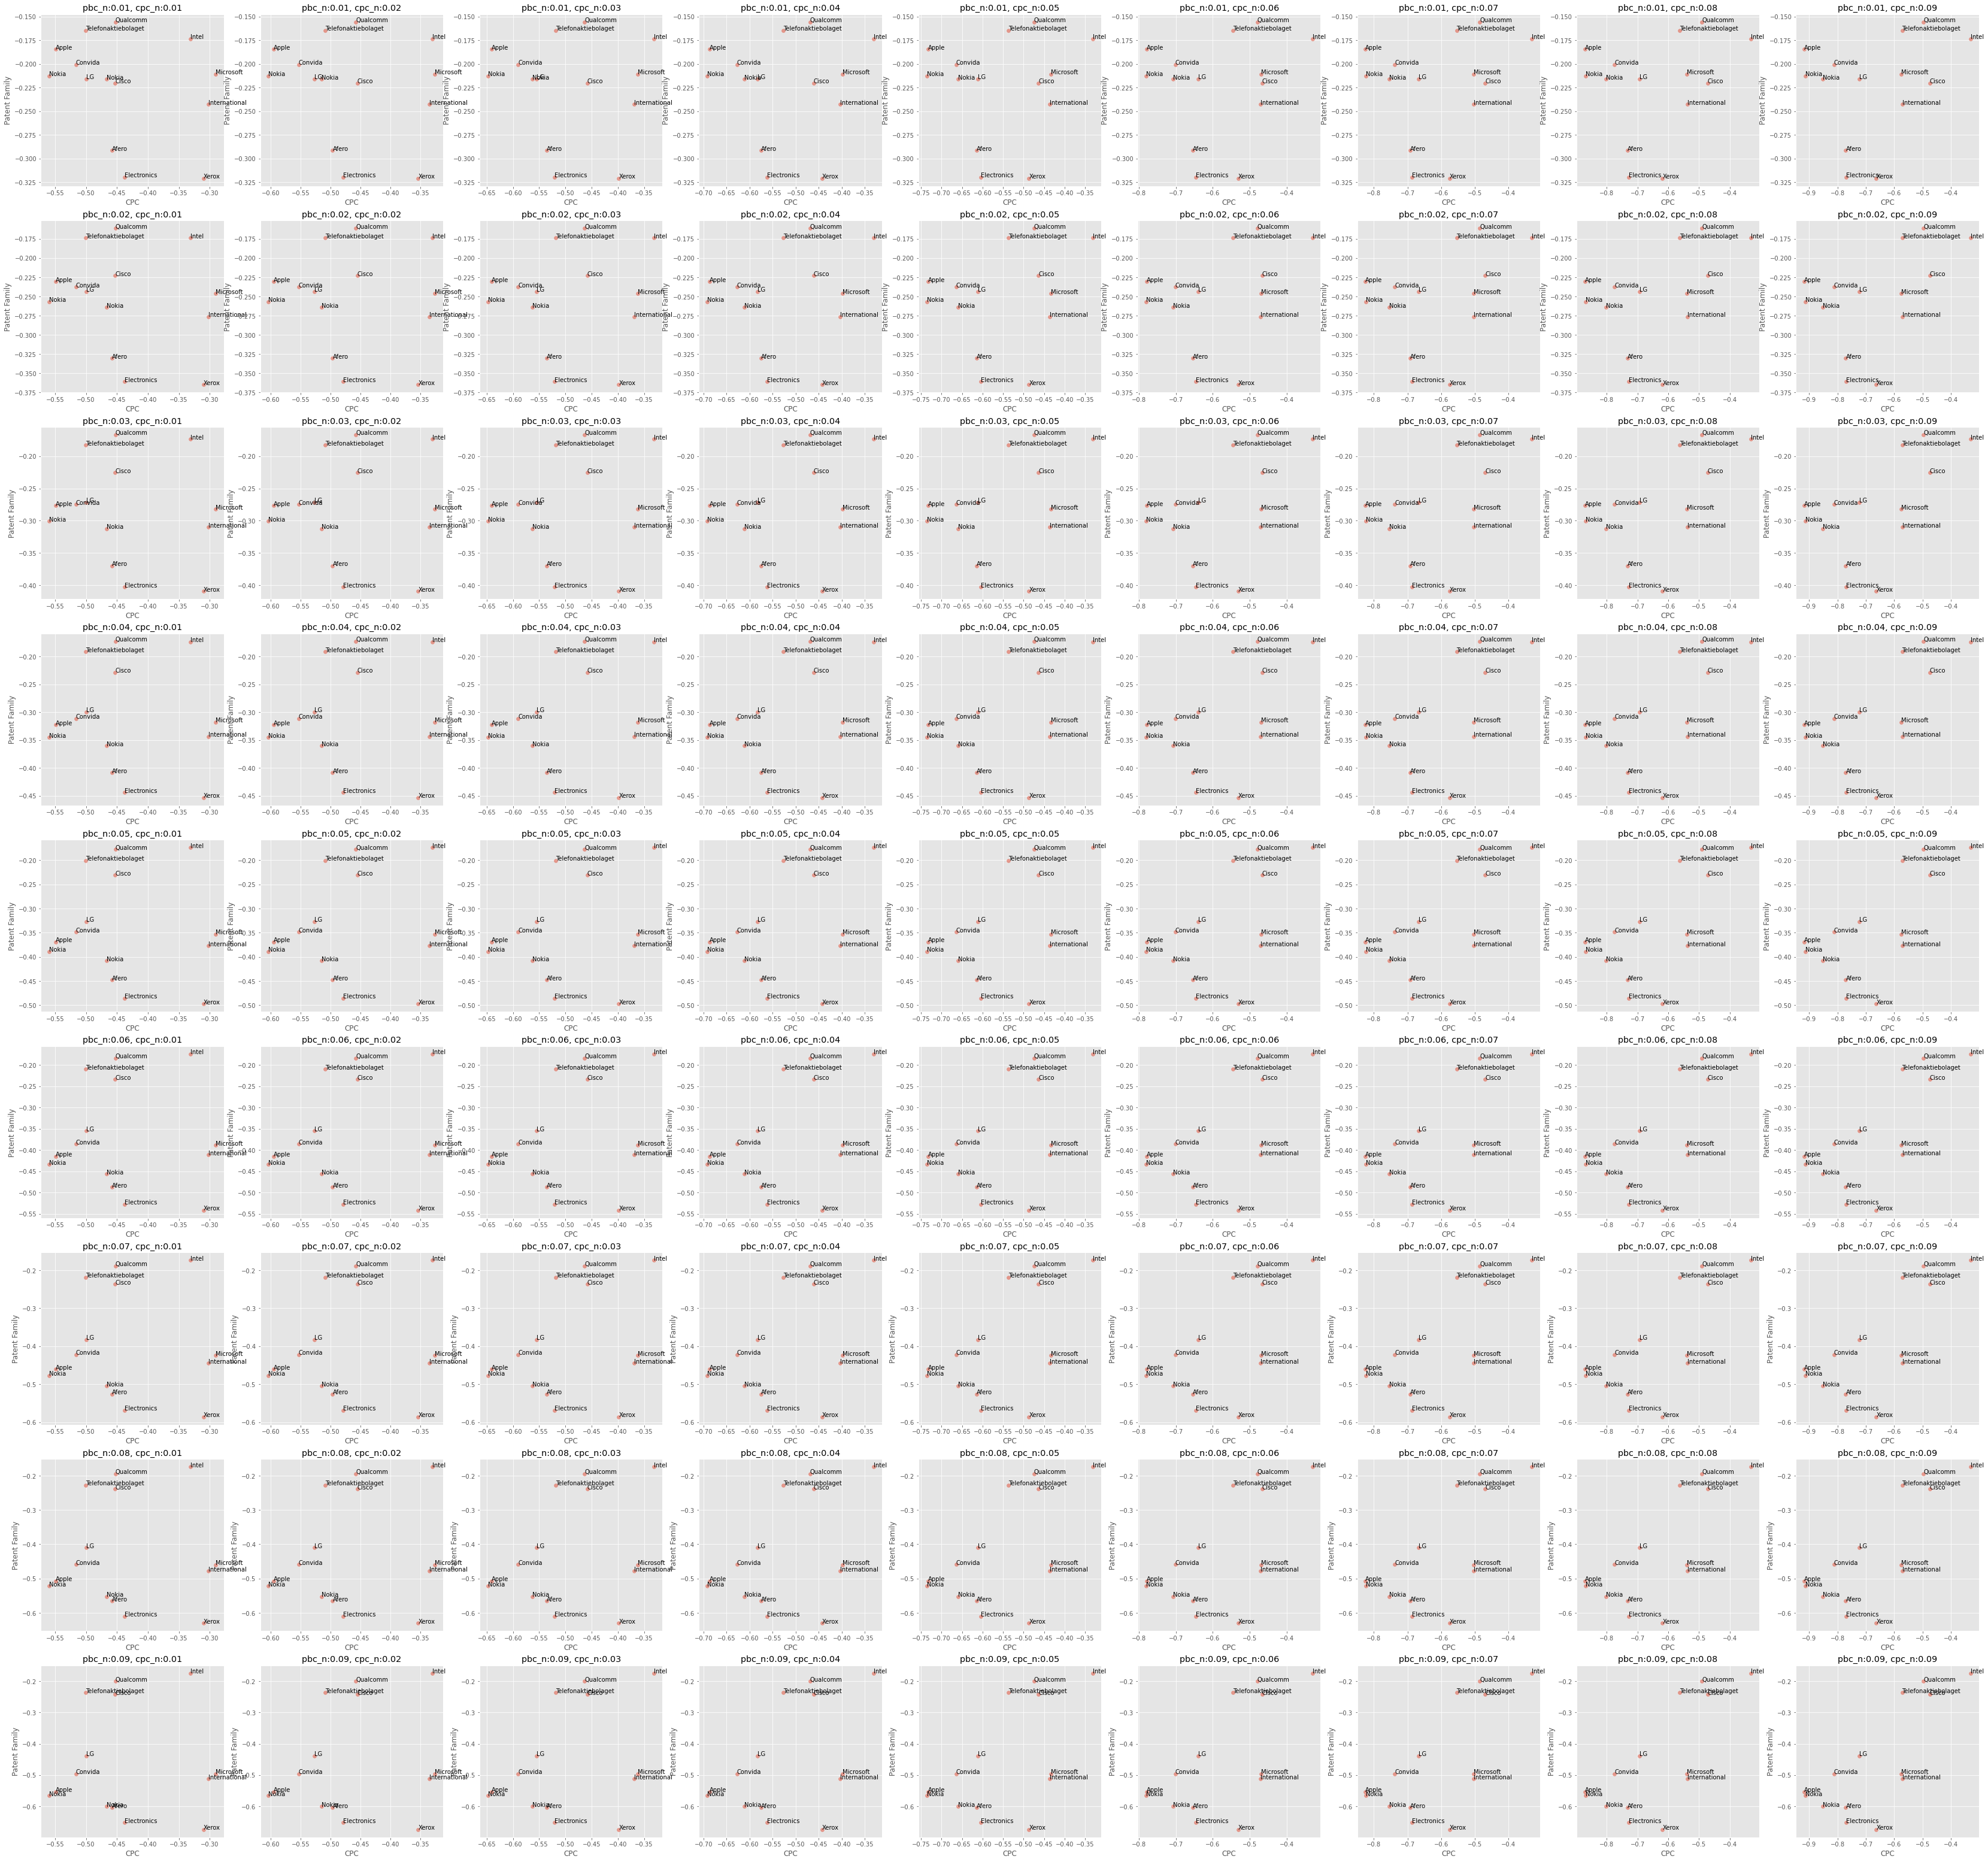

In [41]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_de_us_5_2.png'.format(pbc_n))

In [42]:
c_df

,cpc,country
company,,
Intel Corp,0.331132,0.174023
Cisco Technology Inc,0.474537,0.241625
Qualcomm Inc,0.496464,0.199855
Telefonaktiebolaget LM Ericsson AB,0.572071,0.236360
LG Electronics Inc,0.722142,0.438194
International Business Machines Corp,0.571562,0.512196
Microsoft Technology Licensing LLC,0.575587,0.495556
Convida Wireless LLC,0.811997,0.496233
Afero Inc,0.770781,0.604536
